<a href="https://colab.research.google.com/github/awhb/ml-colaboratory/blob/main/movie_ratings_25m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf

 Data source: https://grouplens.org/datasets/movielens/25m/

In [ ]:
# Read csv files
df_movies = pd.read_csv("movies.csv");
df_ratings = pd.read_csv("ratings.csv");

print(df_movies.head())
print(df_ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


In [ ]:
# Pre-process dataframe of ratings to obtain dataframe of average ratings of each movieId
df_average_ratings = df_ratings.groupby('movieId')['rating'].mean().reset_index()

print(df_average_ratings.head())

   movieId    rating
0        1  3.891078
1        2  3.256774
2        3  3.146718
3        4  2.888509
4        5  3.060153


In [ ]:
# Merge the datasets based on 'movieId'
df = df_movies.reset_index().merge(df_average_ratings.reset_index(), on = 'movieId', how = 'inner')

# Display the merged DataFrame
print(df)

       index_x  movieId                               title  \
0            0        1                    Toy Story (1995)   
1            1        2                      Jumanji (1995)   
2            2        3             Grumpier Old Men (1995)   
3            3        4            Waiting to Exhale (1995)   
4            4        5  Father of the Bride Part II (1995)   
...        ...      ...                                 ...   
43262    62388   209053                      Bowling (2012)   
43263    62389   209055         Very Well, Thank You (2007)   
43264    62394   209069                    Snapshots (2002)   
43265    62401   209103       Tsar Ivan the Terrible (1991)   
43266    62420   209163                    Bad Poems (2018)   

                                            genres  index_y    rating  
0      Adventure|Animation|Children|Comedy|Fantasy        0  3.891078  
1                       Adventure|Children|Fantasy        1  3.256774  
2                          

In [ ]:
# Isolate classification in genres
genres_df = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, genres_df], axis=1)
print(df.head())

   index_x  movieId                               title  \
0        0        1                    Toy Story (1995)   
1        1        2                      Jumanji (1995)   
2        2        3             Grumpier Old Men (1995)   
3        3        4            Waiting to Exhale (1995)   
4        4        5  Father of the Bride Part II (1995)   

                                        genres  index_y    rating  \
0  Adventure|Animation|Children|Comedy|Fantasy        0  3.891078   
1                   Adventure|Children|Fantasy        1  3.256774   
2                               Comedy|Romance        2  3.146718   
3                         Comedy|Drama|Romance        3  2.888509   
4                                       Comedy        4  3.060153   

   (no genres listed)  Action  Adventure  Animation  ...  Film-Noir  Horror  \
0                   0       0          1          1  ...          0       0   
1                   0       0          1          0  ...          0     

In [ ]:
df = df.drop(["index_x", "title", "genres", "index_y"], axis=1)
print(df.head())

   movieId    rating  (no genres listed)  Action  Adventure  Animation  \
0        1  3.891078                   0       0          1          1   
1        2  3.256774                   0       0          1          0   
2        3  3.146718                   0       0          0          0   
3        4  2.888509                   0       0          0          0   
4        5  3.060153                   0       0          0          0   

   Children  Comedy  Crime  Documentary  ...  Film-Noir  Horror  IMAX  \
0         1       1      0            0  ...          0       0     0   
1         1       0      0            0  ...          0       0     0   
2         0       1      0            0  ...          0       0     0   
3         0       1      0            0  ...          0       0     0   
4         0       1      0            0  ...          0       0     0   

   Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0        0       0         0    0  

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [ ]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

_, X_train, y_train = get_xy(train, "rating")
_, X_val, y_val = get_xy(val, "rating")
_, X_test, y_test = get_xy(test, "rating")

In [ ]:
normalizer = tf.keras.layers.Normalization(input_shape=(21,), axis=-1)
normalizer.adapt(X_train)

In [62]:
nn_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error')

In [63]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

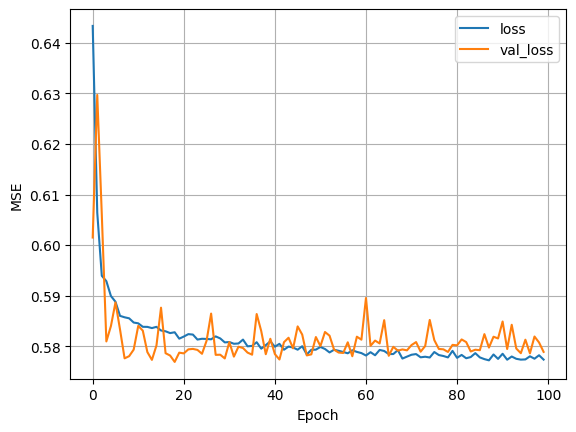

In [64]:
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=0, epochs=100
)

plot_loss(history)

Credits:
Machine Learning for Everybody – Full Course (Kylie Ying) on https://www.youtube.com/watch?v=i_LwzRVP7bg for helper functions